# CutMix 또는 Mixup 비교실험

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


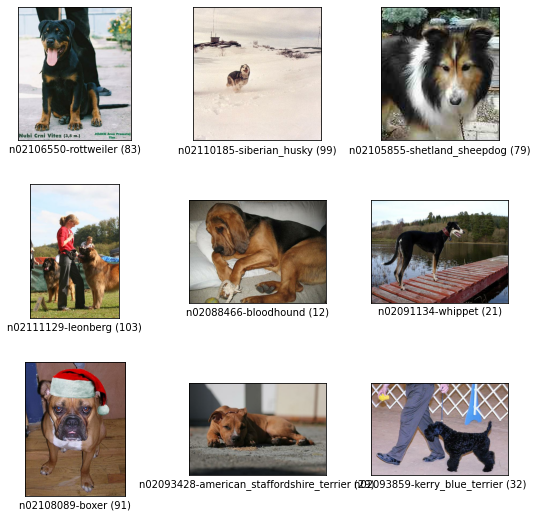

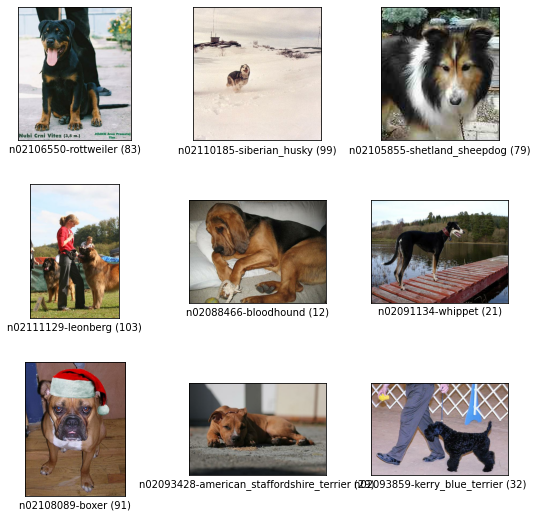

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### Cuxmix

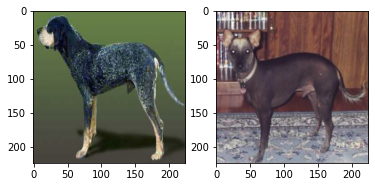

In [9]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(113, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(11, shape=(), dtype=int32) tf.Tensor(197, shape=(), dtype=int32)


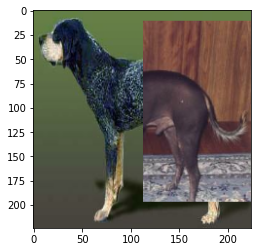

In [11]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [12]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.5885284, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [13]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup

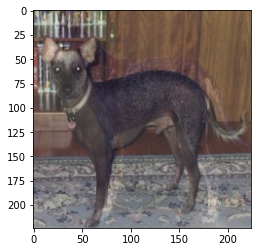

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.25055826 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [14]:
# function for mixup
num_classes = ds_info.features["label"].num_classes
num_classes

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [15]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [16]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 모델 만들기

In [17]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 모델 훈련하기

In [22]:
EPOCH = 20 

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 359s 439ms/step - loss: 3.1660 - accuracy: 0.2820 - val_loss: 3.2916 - val_accuracy: 0.2336
Epoch 2/20
750/750 [==============================] - 334s 446ms/step - loss: 0.8736 - accuracy: 0.7552 - val_loss: 1.1612 - val_accuracy: 0.6622
Epoch 3/20
750/750 [==============================] - 336s 447ms/step - loss: 0.3288 - accuracy: 0.9212 - val_loss: 0.9475 - val_accuracy: 0.7236
Epoch 4/20
750/750 [==============================] - 335s 447ms/step - loss: 0.0990 - accuracy: 0.9879 - val_loss: 0.9082 - val_accuracy: 0.7359
Epoch 5/20
750/750 [==============================] - 336s 448ms/step - loss: 0.0322 - accuracy: 0.9989 - val_loss: 0.9160 - val_accuracy: 0.7415
Epoch 6/20
750/750 [==============================] - 335s 447ms/step - loss: 0.0188 - accuracy: 0.9992 - val_loss: 0.9244 - val_accuracy: 0.7460
Epoch 7/20
750/750 [==============================] - 335s 447ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.9334 -

In [24]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 342s 449ms/step - loss: 3.2462 - accuracy: 0.2689 - val_loss: 2.8796 - val_accuracy: 0.2875
Epoch 2/20
750/750 [==============================] - 336s 447ms/step - loss: 1.0916 - accuracy: 0.6851 - val_loss: 1.2731 - val_accuracy: 0.6416
Epoch 3/20
750/750 [==============================] - 335s 447ms/step - loss: 0.5617 - accuracy: 0.8486 - val_loss: 1.0677 - val_accuracy: 0.6913
Epoch 4/20
750/750 [==============================] - 335s 447ms/step - loss: 0.3002 - accuracy: 0.9242 - val_loss: 1.0641 - val_accuracy: 0.6960
Epoch 5/20
750/750 [==============================] - 335s 447ms/step - loss: 0.1613 - accuracy: 0.9691 - val_loss: 0.9882 - val_accuracy: 0.7213
Epoch 6/20
750/750 [==============================] - 336s 448ms/step - loss: 0.0896 - accuracy: 0.9855 - val_loss: 1.0552 - val_accuracy: 0.7126
Epoch 7/20
750/750 [==============================] - 335s 447ms/step - loss: 0.0544 - accuracy: 0.9929 - val_loss: 1.0380 -

In [25]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 345s 451ms/step - loss: 4.3736 - accuracy: 0.1088 - val_loss: 3.4443 - val_accuracy: 0.1947
Epoch 2/20
750/750 [==============================] - 337s 450ms/step - loss: 3.0408 - accuracy: 0.3987 - val_loss: 1.3702 - val_accuracy: 0.6181
Epoch 3/20
750/750 [==============================] - 338s 450ms/step - loss: 2.6842 - accuracy: 0.5144 - val_loss: 1.2314 - val_accuracy: 0.6547
Epoch 4/20
750/750 [==============================] - 337s 450ms/step - loss: 2.4832 - accuracy: 0.5819 - val_loss: 1.2394 - val_accuracy: 0.6592
Epoch 5/20
750/750 [==============================] - 337s 450ms/step - loss: 2.3277 - accuracy: 0.6372 - val_loss: 1.2293 - val_accuracy: 0.6576
Epoch 6/20
750/750 [==============================] - 337s 450ms/step - loss: 2.1736 - accuracy: 0.6797 - val_loss: 1.1759 - val_accuracy: 0.6792
Epoch 7/20
750/750 [==============================] - 338s 450ms/step - loss: 2.0974 - accuracy: 0.7029 - val_loss: 1.1667 -

In [26]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 344s 451ms/step - loss: 4.2795 - accuracy: 0.1241 - val_loss: 3.9525 - val_accuracy: 0.1251
Epoch 2/20
750/750 [==============================] - 337s 450ms/step - loss: 2.9624 - accuracy: 0.4376 - val_loss: 1.4819 - val_accuracy: 0.5772
Epoch 3/20
750/750 [==============================] - 337s 449ms/step - loss: 2.6359 - accuracy: 0.5657 - val_loss: 1.3088 - val_accuracy: 0.6295
Epoch 4/20
750/750 [==============================] - 337s 449ms/step - loss: 2.4435 - accuracy: 0.6392 - val_loss: 1.2344 - val_accuracy: 0.6643
Epoch 5/20
750/750 [==============================] - 337s 450ms/step - loss: 2.2966 - accuracy: 0.6835 - val_loss: 1.2433 - val_accuracy: 0.6622
Epoch 6/20
750/750 [==============================] - 337s 450ms/step - loss: 2.2025 - accuracy: 0.7404 - val_loss: 1.3220 - val_accuracy: 0.6442
Epoch 7/20
750/750 [==============================] - 337s 450ms/step - loss: 2.1161 - accuracy: 0.7593 - val_loss: 1.2532 -

## 훈련 과정 시각화하기

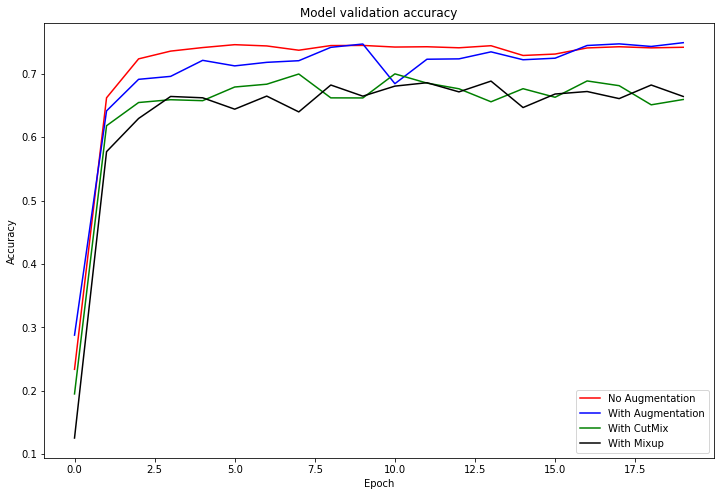

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'])
plt.show()

## Augmentation에 의한 모델 성능 비교
예상 외로 cutmix와 mixup을 적용한 모델의 성능이 적용하지 않은 모델보다 정확도가 떨어지는 모습을 보인다.  